# Volatility tracking

This is another notebook where I use the Kalman filter to track hidden variables.      
This time it's the turn of **volatility**!     
Well, actually I will track the variance, but the concept is the same.

I will use the values simulated by a Heston process, and implement several methods to track the (hidden) volatility process.
We will compare the simple "rolling" method with the very famous GARCH(1,1) method, and we will see that the Kalman filter is slightly superior to both of them.

This notebook also contains a small digression on the Variance Gamma process, which however is not related to the main theme and therefore you can skip it if you are not interested.

In this notebook, I will make use of the [ARCH](https://arch.readthedocs.io/en/latest/index.html) library, which is not present in the docker container that I suggested to use. So it is better to create a virtual environment with the packages suggested in the "requirements.txt" file, or simply install ARCH by yourself on your system.

## Contents
   - [Heston Path generation](#sec1) 
      - [Log-return analysis](#sec1.1)
      - [Hypothesis testing](#sec1.2)
      - [A digression on the Variance Gamma process](#sec1.3)
   - [Garch(1,1)](#sec2)
      - [GARCH with the arch library](#sec2.1)
      - [GARCH from scratch](#sec2.2)
      - [Rolling variance](#sec2.3)
   - [Kalman filter](#sec3)
      - [Linear Gaussian State Space Model](#sec3.1)
      - [Algorithm implementation](#sec3.2)

In [1]:
import numpy as np
import scipy.stats as ss
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
from functions.Processes import Heston_process, VG_process, GARCH
from arch.unitroot import PhillipsPerron, KPSS, ADF
from arch import arch_model
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.stattools import pacf
import matplotlib.gridspec as gridspec
from functions.probabilities import VG_pdf
from scipy.integrate import quad
from scipy.optimize import minimize
#from importlib import reload

<a id='sec1'></a>
# Heston path generation

Let us consider a stock price $\{S_t\}_{t\geq 0}$ following a Heston process. We introduced the Heston process in the notebook **1.4**, but it is better to recall the SDE: 

$$ \begin{cases}
dS_t = \mu S_t dt + \sqrt{v_t} S_t dW^1_t \\
dv_t = \kappa (\theta - v_t) dt + \sigma \sqrt{v_t} dW^2_t 
\end{cases}$$

The process $\{v_t\}_{t\geq 0}$ is the variance process and follows a CIR process (see notebook **1.2**).     

The parameters are:
- $\mu$ drift of the stock process
- $\kappa$ mean reversion coefficient of the variance process
- $\theta$ long term mean of the variance process 
- $\sigma$  volatility coefficient of the variance process
- $\rho$ correlation between $W^1$ and $W^2$.

I will simulate the process considering `N=2500` time points and `T=10` years. This is quite realistic as in ten years there are about 2500 days.

In [2]:
N = 2500                                                      # time points 
T = 10                                                        # time in years  
T_vec, dt = np.linspace(0,T,N, retstep=True )                 # time vector and time step
S0 = 100                                                      # initial price
v0 = 0.04                                                     # initial variance 
mu = 0.1; rho = -0.1; kappa = 5; theta = 0.04; sigma = 0.6    # alternative values: rho=-0.3 kappa=15 sigma=1
std_asy = np.sqrt( theta * sigma**2 /(2*kappa) )              # asymptotic standard deviation for the CIR process
assert(2*kappa * theta > sigma**2)                            # Feller condition

Let us generate the path using the function `Heston_process.path`.

In [3]:
np.random.seed(seed=42) 
Hest = Heston_process(mu=mu, rho=rho, sigma=sigma, theta=theta, kappa=kappa)
S, V = Hest.path(S0, v0, N, T)      # S is the stock, V is the variance

##### Plot:

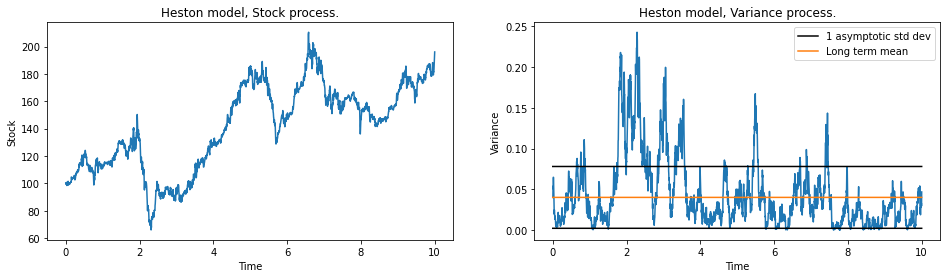

In [4]:
fig = plt.figure(figsize=(16,4))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
ax1.plot(T_vec, S )
ax1.set_title("Heston model, Stock process."); ax1.set_xlabel("Time"); ax1.set_ylabel("Stock")
ax2.plot(T_vec, V )
ax2.set_title("Heston model, Variance process."); ax2.set_xlabel("Time"); ax2.set_ylabel("Variance")
ax2.plot(T_vec, (theta + std_asy)*np.ones_like(T_vec), label="1 asymptotic std dev", color="black" )
ax2.plot(T_vec, (theta - std_asy)*np.ones_like(T_vec), color="black" )
ax2.plot(T_vec, theta*np.ones_like(T_vec), label="Long term mean" )
ax2.legend(loc="upper right"); plt.show()

<a id='sec1.1'></a>
## Log-return analysis

Let us compute the **log-returns** and **linear (or net) returns**.       
It turns out that it is almost the same to work with log-returns or linear returns.     
For small $\Delta t$, we can use a first order Taylor expansion (around 1):

$$ \log \frac{S_{t+\Delta t}}{S_t} \; \approx \; \frac{S_{t+\Delta t}}{S_t} -1 $$

In [5]:
ret_log = np.log(S[1:]/S[:-1])        # log returns
ret_pct = S[1:] / S[:-1] - 1          # linear net returns

##### Fit of Variance Gamma and Student t

I will explain in the [VG Section](#sec1.3) why I chose the Variance Gamma distribution among many others.

In [6]:
VG = VG_process()
VG.fit_from_data( ret_log, dt, "Nelder-Mead" )  # or "MM" (methods of moments), or "L-BFGS-B" that does not work
print("VG parameters:", VG.c, VG.theta, VG.sigma, VG.kappa)

Optimization terminated successfully.
VG parameters: 0.0005194485663832025 -0.05548824186766799 0.20503868767677264 0.003450210420172355


In [7]:
params = ss.t.fit(ret_log)
print("Student-t parameters", params)   # degrees of freedom, location, scale

Student-t parameters (3.5313949443738206, 0.0003999362308227026, 0.009120671213235513)


Let us compute the mean and standard deviation for both log-returns and linear returns. I present the normalized values i.e. the values computed for $T=1$.     
Adding the approximated Itô correction $\frac{1}{2}\theta$, the two means becomes almost equal (see below for a better explanation). 

In [8]:
mean_log = ret_log.mean(); std_log = ret_log.std()
mean_pct = ret_pct.mean(); std_pct = ret_pct.std()
print("Log-returns, normalized mean={:.4f} and std={:.4f}".format(mean_log/dt, std_log/np.sqrt(dt)) )
print("Corrected mean={:.4f} by approximated Itô correction".format(mean_log/dt + 0.5*theta) )
print("Linear returns, normalized mean={:.4f} and std={:.4f}".format(mean_pct/dt, std_pct/np.sqrt(dt)) )

Log-returns, normalized mean=0.0673 and std=0.2065
Corrected mean=0.0873 by approximated Itô correction
Linear returns, normalized mean=0.0887 and std=0.2066


Below, you can see the returns histogram with some fitted distributions, the qq-plot and the plot of the log-return process.    
As expected, the normal distribution underestimates the mass around the mean. From the histogram it is difficult to notice the presence of heavy tails. For this reason I included the qqplot as well.    
The plot of the log-returns dynamics includes the mean and standard deviation levels. It clearly exhibits volatility clustering.

<a id='hist'></a>
##### Plot

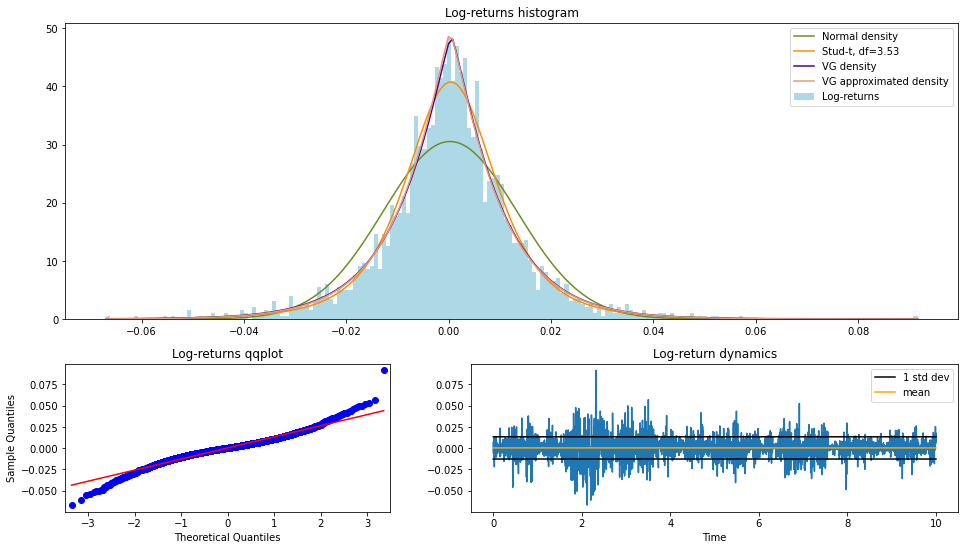

In [9]:
x = np.linspace(ret_log.min(), ret_log.max(), 200)
fig = plt.figure(figsize=(16,9));  gs = gridspec.GridSpec(2, 2, height_ratios=[2,1])
gs00 = gs[1,:].subgridspec(1, 2, width_ratios=[2,3])
ax1 = fig.add_subplot(gs[0, :]); ax2 = fig.add_subplot(gs00[0, 0]); ax3 = fig.add_subplot(gs00[0, 1])
ax1.plot(x, ss.norm.pdf(x, mean_log, std_log), color='olivedrab', label="Normal density")
ax1.plot(x, ss.t.pdf(x, loc=params[1], scale=params[2], df=params[0]), color="darkorange",
         label="Stud-t, df={}".format(params[0].round(2) ))
ax1.plot(x, VG_pdf(x, dt, VG.c, VG.theta, VG.sigma, VG.kappa ), color='indigo', label="VG density")
ax1.plot(x, VG_pdf(x, dt, VG.c+VG.theta*dt, 0, np.sqrt(VG.var), VG.kappa ), 
         color='darksalmon', label="VG approximated density")
ax1.hist(ret_log, density=True, bins=200, facecolor="LightBlue", label="Log-returns")
ax1.legend(); ax1.set_title("Log-returns histogram")
ax2.set_title("Log-returns qqplot");  qqplot(ret_log, line='s', ax=ax2)
ax3.plot(T_vec[1:], ret_log); ax3.set_title("Log-return dynamics")
ax3.plot(T_vec[1:], (mean_log + std_log)*np.ones(N-1), label="1 std dev", color="black" )
ax3.plot(T_vec[1:], (mean_log - std_log)*np.ones(N-1), color="black" )
ax3.plot(T_vec[1:], mean_log*np.ones(N-1), color="orange", label="mean" ); ax3.set_xlabel("Time")
ax3.legend(); plt.show()

From now on, the quantity of interest will be the **stock return** $R_t$.    
As we have seen above, there is no big difference between using log-returns or linear returns. 

Since we will work with a time series of data, it is better to consider a discrete-time model (with $\Delta t = 1$), that can be derived from the discretization of the SDE we have seen before.

1) Linear returns, $ R_{t+1} := \frac{S_{t+1}}{S_t} -1  $:

We can discretize the equation of the process $\{S_t\}_{t\geq0}$ in the Heston SDE introduced on top of this notebook (the Euler-Maruyama discretization procedure is presented in the notebook **1.2**):

$$ R_{t+1} = \mu + \sqrt{v_t} \Delta W_{t} $$

with $\Delta W_{t} = W_{t+1} - W_{t}$.

2) Log-returns,  $ R_{t+1} := \log \frac{S_{t+1}}{S_t} $:

You should make a change of variable into the Heston SDE (see what I did in the notebook **1.4**) and then discretize. 

$$ R_{t+1} = \mu - \frac{1}{2}v_t + \sqrt{v_t} \Delta W_{t} $$

In the linear returns equation we have a constant drift $\mu$, but in the log-return equation the drift $\mu - \frac{1}{2}v_t$ is stochastic.

Since we are interested in the volatility, there is no need of a drift term. It turns out that it is almost always possible to detrend a time series.   
If the trend is constant we can simply define $\tilde R_{t} := R_{t} - \mu$. If the trend is stochastic, detrending is more complicated but still possible.    
In particular, in the process above the effect of the stochasticity in the trend is negligible for big values of $T$. Since the trend is a mean reverting process, we can approximate the mean with its long term mean $\mathbb{E}\big[ v_t \big] \approx \theta$. Let us check it is correct.    
From the [CIR conditional expectation](https://en.wikipedia.org/wiki/Cox%E2%80%93Ingersoll%E2%80%93Ross_model#Properties) formula, we can use the tower property:

$$ \mathbb{E}\big[ v_t \,\big|\, \mathcal{F}_0 \big] = \mathbb{E}\bigg[ \mathbb{E}\big[ v_t \big| v_{t-1} \big] \, \bigg|\, \mathcal{F}_0 \bigg] = \mathbb{E}\bigg[ v_{t-1} e^{-\kappa \Delta t} + \theta (1-e^{-\kappa \Delta t}) \, \bigg|\, \mathcal{F}_0 \bigg] = \mathbb{E}\big[ v_{t-1} \, \big|\, \mathcal{F}_0 \big] e^{-\kappa \Delta t} + \theta (1-e^{-\kappa \Delta t})  $$

For $t \gg 0$ ($t$ much bigger than zero) we can write $\mathbb{E}\big[ v_t \,\big|\, \mathcal{F}_0 \big] \approx \mathbb{E}\big[ v_{t-1} \,\big|\, \mathcal{F}_0 \big] \approx \mathbb{E}\big[ v_t \big]$ where the dependency on the initial information $\mathcal{F}_0$ decays.
Solving the equation we get $\mathbb{E}\big[ v_t \big] \approx \theta$. 

We can detrend the series by redefining $\tilde R_{t} := R_{t} - \mathbb{E}[R_{t}] = R_{t} - \mu + \frac{1}{2}\theta$.     
I called the term $\frac{1}{2}\theta$, *approximated Itô correction*.  

We obtain a unified model that works for both linear and log returns (we can suppress the tilde):

$$ R_{t+1} = \sqrt{v_t}\, \epsilon_{t+1} $$

with $\epsilon_t \sim \mathcal{N}(0,1)$ for each $t$. 

<a id='sec1.2'></a>
## Hypothesis testing

Let us investigate the statistical properties of this log-return time series.

For this purpose I want to perform some tests:

Stationarity tests:

- The Augmented Dickey-Fuller test [wiki](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test)    
The null hypothesys is that the process is unit root.


- The Phillips-Perron test [wiki](https://en.wikipedia.org/wiki/Phillips%E2%80%93Perron_test)     
The test is robust with respect to unspecified autocorrelation and heteroscedasticity. The null hypothesys is that the process is unit root.


- Kwiatkowski–Phillips–Schmidt–Shin tests [wiki](https://en.wikipedia.org/wiki/KPSS_test)    
The null hypothesys is that the process is NOT unit root.

Let us also conside the [Jarque-Bera](https://en.wikipedia.org/wiki/Jarque%E2%80%93Bera_test) test for normality and the [Ljung-Box](https://en.wikipedia.org/wiki/Ljung%E2%80%93Box_test) test for autocorrelation.

In [10]:
print("Augmented Dickey Fuller test: p-value = ", ADF(ret_log, trend='nc').pvalue)
print("Phillips Perron test: p-value = ", PhillipsPerron(ret_log, trend='nc').pvalue)
print("KPPS test: p-value = ", KPSS(ret_log).pvalue.round(4))
print()
print("Jarque-Bera (H0=normal), p-value = ", ss.jarque_bera(ret_log)[1] )
print("Ljung-Box test (H0=independent) for lag 1 to 3, p-values = ", 
                           sm.stats.acorr_ljungbox(ret_log, lags=3, return_df=False)[1])
print("Ljung-Box test on the squared returns, p-values = ", 
                           sm.stats.acorr_ljungbox(ret_log**2, lags=3, return_df=False)[1] )

Augmented Dickey Fuller test: p-value =  0.0
Phillips Perron test: p-value =  0.0
KPPS test: p-value =  0.817

Jarque-Bera (H0=normal), p-value =  0.0
Ljung-Box test (H0=independent) for lag 1 to 3, p-values =  [0.34843522 0.4224824  0.61618723]
Ljung-Box test on the squared returns, p-values =  [1.14275887e-18 3.49742191e-38 1.86949489e-47]


#### Comments:

1) The plot of the log-return dynamics suggests that the series is weak stationary (i.e. with constant unconditional mean and variance), but has non-constant conditional variance. This time series clearly exhibits **volatility clustering**.    
The first three tests all confirm the weak stationarity!    
Since the process has conditional heteroscedasticity, the most appropriate test to use in this case is the PhillipsPerron, which is very robust with respect to nonconstant variances. 
In [1], it is shown that smooth and periodic variations in the variance have a negligible effect on the ADF test output, which makes it quite reliable as well. 

2) The Jarque-Bera test confirms what we saw in the histogram and in the qqplot i.e. that the log-returns distribution is not normal.

3) The Ljung-Box test on the log-returns shows high p-values. Thus we cannot reject the independence hypothesis (we know that log-returns are independent).  
However, the same test applied to the squared log-returns shows very small p-values, confirming the presence of autocorrelation. **Volatility clustering can be detected by checking
for correlations between the squared returns.**

##### Parameters choice

When I chose the parameters of the CIR process $v_t$, I had to select the parameters $\rho$, $\kappa$ and $\sigma$ such that the stationarity and the volatility clusters can be detected from the simulated data.     
The mean reversion parameter $\kappa$ should be big enough to make the process stationary. On the other hand, if $\kappa$ is too big, the variance process reverts too fast towards its long term mean, and the log-returns do not exhibit the volatility clusters.     
If $\sigma$ is too small, the process always stays near the long term mean, and clusters do not form.

In [11]:
print("Augmented Dickey Fuller test for the variance process: p-value = ", ADF(V, trend='nc').pvalue)
print("Using the PACF we can calculate phi={:.4f}. It is very close to the theoretical value phi={:.4f}".format(
                            pacf(V, nlags=1)[1], np.exp(-kappa*dt)) )

Augmented Dickey Fuller test for the variance process: p-value =  0.0011940495803608193
Using the PACF we can calculate phi=0.9833. It is very close to the theoretical value phi=0.9802


The ADF test shows that the process is indeed stationary.

We don't know the solution of the CIR equation, but we know its conditional expectation 

$$\mathbb{E}\big[ v_t \big| v_{t-1}\big] = \phi v_{t-1} + const, $$ 

with $\phi=e^{-\kappa \Delta t}$.     
In order to have stationarity we must have $|\phi|<1$.  A small $\kappa$ makes $\phi \approx 1$ and the process becomes similar to a unit root.  

From the last expression, we see that also the size of $\Delta t$ matters. 
When $\Delta t \to 0$ then $\phi \to 1$.     
Choosing bigger value of $N$, may create problems in the detection of stationarity.      
This is a consequence of the fact that **for short time scales, a mean-reverting process is indistinguishable from a random walk** (remember that in an autoregressive model when $|\phi|=1$ the process is unit root).

<a id='sec1.3'></a>
## A digression on the Variance Gamma (VG) process

Above I plotted the log-returns histogram together with some fitted distributions: the normal, the Student-t and the VG distributions.     
You may ask yourself why I decided to include the VG distribution in the plot. If you look carefully, you can see that it fits the data really good!

If you need to review the VG process, have a look at the notebook **1.5**.    
Important to know, is that the process is obtained by Brownian subordination (i.e. the time $t$ in the Brownian motion is assumed to be a gamma process) and is defined as: 

$$ X_{t} = \theta T_t + \sigma W_{T_t} $$ 

where $W_{T_t} \sim \mathcal{N}(0,T_t)$ and $T_t \sim \Gamma(\text{mean}=t, \text{var}=\kappa t)$.    
I'm using the same letters $(\theta, \sigma, \kappa)$ used for the Heston parameters, but remember that they have a different meaning: $\theta$ and $\sigma$ are the drift and std dev of the Brownian motion, and $\kappa$ is the variance coefficient of the Gamma process.

Alright,     
let us try to answer the following three questions:

1) How good is the VG fit?     
2) How can we measure the quality of the fit?    
3) Why the VG process among many others?    

In order to answer the first two questions, let us define the Empirical-Cumulative-Distribution-Function [ECDF](https://en.wikipedia.org/wiki/Empirical_distribution_function):

$$ \hat F_n(x) = \frac{1}{n} \sum_{i=1}^{n} \mathbb{1}_{X_i \leq x} $$

Unlike the histogram, the ECDF had the advantage that it does not depend on the number of bins.     
We can compare the ECDF with the **Normal**, **Student-t** and **VG** theoretical cumulative distributions. 

In [12]:
def ECDF(data):
    """ ECDF """
    x = np.sort(data)
    n = x.size
    y = np.arange(1, n+1) / n
    return x, y

In [13]:
xx, yy = ECDF(ret_log)
VG_cdf = np.array([ quad(VG_pdf, -1, i, args=(dt, VG.c, VG.theta, VG.sigma, VG.kappa))[0] for i in xx])

##### Plot

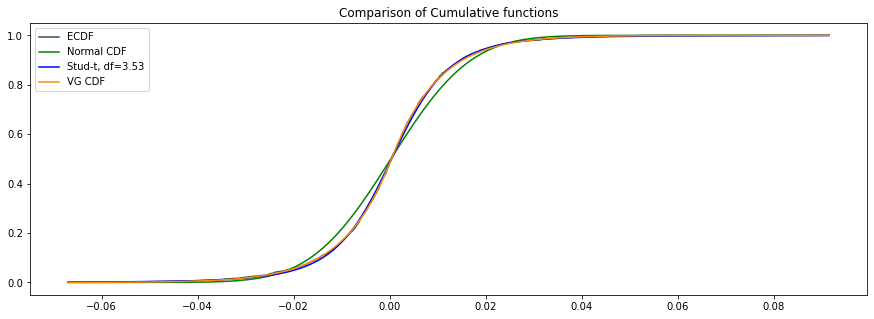

In [14]:
fig = plt.figure(figsize=(15,5))
plt.plot(xx, yy, color="darkslategray", label="ECDF")
plt.plot(xx, ss.norm.cdf(xx, loc=mean_log, scale=std_log), color="green", label="Normal CDF" )
plt.plot(xx, ss.t.cdf(xx, loc=params[1], scale=params[2], df=params[0]), color="blue",
         label="Stud-t, df={}".format(params[0].round(2) ))
plt.plot(xx, VG_cdf, label="VG CDF", color="darkorange" )
plt.title("Comparison of Cumulative functions"); plt.legend(); plt.show()

Looking at the plot above, we can understand better which distribution fits better the data.    

In order to have a quantitative measure of the goodness of fit, we can calculate the Euclidean distance between the theoretical and the empirical CDFs.

In [15]:
print("Distance VG-ECDF: ", np.linalg.norm(VG_cdf-yy, ord=2) )
print("Distance Student-t-ECDF: ", np.linalg.norm(
                        ss.t.cdf(xx, loc=params[1], scale=params[2], df=params[0]) - yy, ord=2) )
print("Distance Normal-ECDF: ", np.linalg.norm(ss.norm.cdf(xx, loc=mean_log, scale=std_log) - yy, ord=2) )

Distance VG-ECDF:  0.14036719864722175
Distance Student-t-ECDF:  0.34203476140854494
Distance Normal-ECDF:  1.9583261648228154


###### Now we have the confirmation that the VG distribution works very well!!

Ok, but are there any theoretical motivations?

The answer is **yes**!  

1) The variance of the Heston process follows the CIR process. I introduced the CIR process in the notebook **1.2**, where we saw that the conditional distribution of the process is a non-central chi-squared distribution. However, as time becomes large, the asymptotic distribution tends to the Gamma distribution:

$$ f(v; \alpha, \beta ) = \frac{\beta^{\alpha}}{\Gamma(\alpha)} v^{\alpha-1} e^{-\beta v} $$
where $\alpha = \frac{2 \theta \kappa}{\sigma^2}$ and $\beta= \frac{2 \kappa}{\sigma^2}$.

2) In the VG process $X_{t} = \theta T_t + \sigma W_{T_t}$, the variance of the Brownian motion is Gamma distributed. I will use an heuristic Brownian approximation.    
Since $\mathbb{E}[X_t] = \theta t$ and $Var[X_{t}] = (\sigma^2 + \theta^2 \kappa) t$, we can define $\sigma^2_{VG} = \sigma^2 + \theta^2 \kappa$ and write: 

$$ X_{t} \approx \theta t + \sigma_{VG} W_{T_t} $$ 

where, by the law of total variance, $Var \big[ W_{T_t} \big] = t$. The approximated model has same mean and same variance of the original VG process.   

The process $\sigma_{VG} W_{T_t}$ is known as the **symmetric Variance Gamma** process (the parameter $\theta$ is the responsible for the skewness, if $\theta=0$ the density is symmetric).     
The distribution of the approximated process can be obtained from `VG_pdf`, the VG distribution $f^{VG}(x; t, c, \theta, \sigma, \kappa)$, by setting the parameters 

$$ c= c+\theta t \quad \theta=0 \quad \sigma=\sigma_{VG} \quad \kappa=\kappa $$ 

In the [plot above](#hist), we plotted both the VG and approximated VG densities. 
It is very hard to distinguish them. **In this case the approximation is very good!** 

The conditional variance of the symmetric VG is: 

$$ Var \big[ \sigma_{VG} W_{T_t} \,\big|\, T_t \big] \,=\, \sigma^2_{VG} T_t \,\sim \, \Gamma \big( \text{shape=}\frac{t}{\kappa}, \, \text{scale=} \sigma^2_{VG} \big) $$ 

Therefore...      
In both cases 1) and 2), the variance is described by a Gamma distribution.   
Let us plot the two Gammas, together with a Gamma distribution fitted from the data. 

In [16]:
params2 = ss.gamma.fit(V , floc=0)       # fit from data
beta = 2*kappa/sigma**2
alpha = 2*kappa*theta/sigma**2

In [17]:
vg_path = VG.path(T=T, N=N)[0]           # VG path        
vg_ret = vg_path[1:] - vg_path[:-1]      # VG increments 

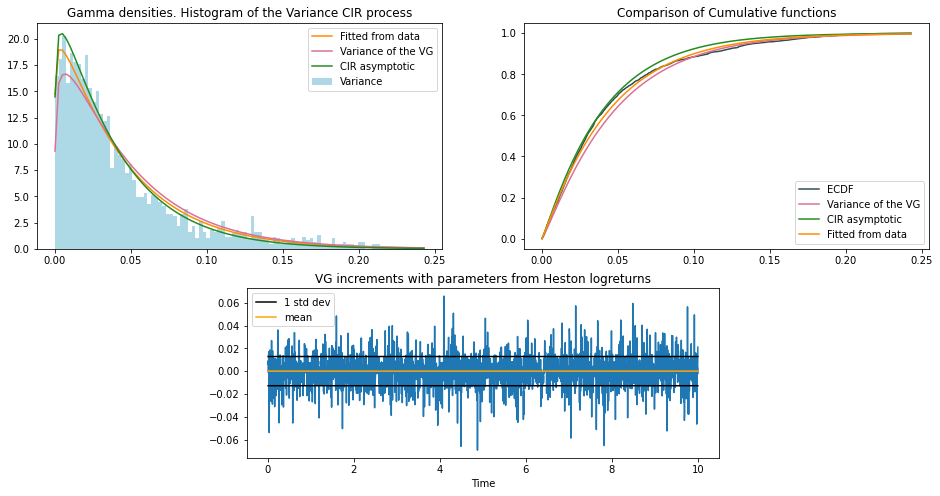

In [18]:
fig = plt.figure(figsize=(16,8));  gs = gridspec.GridSpec(2, 2, height_ratios=[4,3])
gs00 = gs[1,:].subgridspec(1, 3, width_ratios=[1,3,1])
ax1 = fig.add_subplot(gs[0, 0]); ax2 = fig.add_subplot(gs00[0,1]); ax3 = fig.add_subplot(gs[0, 1])
xxx = np.linspace(V.min(),V.max(), 100)
xxxx, yyyy = ECDF(V)
ax1.plot(xxx, ss.gamma.pdf(xxx, a=params2[0], loc=params2[1], scale=params2[2]), color="darkorange",
         label="Fitted from data"); ax1.set_title("Gamma densities. Histogram of the Variance CIR process") 
ax1.plot(xxx, ss.gamma.pdf(xxx, a=dt/VG.kappa, scale=VG.var ), color="palevioletred", label="Variance of the VG")
ax1.plot(xxx, ss.gamma.pdf(xxx, a=alpha, scale=1/beta ), color="forestgreen", label="CIR asymptotic")
ax1.hist(V, density=True, bins=100, facecolor="LightBlue", label="Variance"); ax1.legend()
ax2.plot(T_vec[1:], vg_ret)
ax2.plot(T_vec[1:], (VG.mean*dt + np.sqrt(VG.var*dt) )*np.ones(N-1), label="1 std dev", color="black" )
ax2.plot(T_vec[1:], (VG.mean*dt - np.sqrt(VG.var*dt) )*np.ones(N-1), color="black" )
ax2.plot(T_vec[1:], VG.mean*dt*np.ones(N-1), color="orange", label="mean" ) 
ax2.set_xlabel("Time"); ax2.legend(); ax2.set_title("VG increments with parameters from Heston logreturns");
ax3.plot(xxxx, yyyy, color="darkslategray", label="ECDF")
ax3.plot(xxxx, ss.gamma.cdf(xxxx, a=dt/VG.kappa, scale=VG.var ), color="palevioletred", label="Variance of the VG")
ax3.plot(xxxx, ss.gamma.cdf(xxxx, a=alpha, scale=1/beta ), color="forestgreen", label="CIR asymptotic")
ax3.plot(xxxx, ss.gamma.cdf(xxxx, a=params2[0], loc=params2[1], scale=params2[2]), color="darkorange",
         label="Fitted from data")
ax3.set_title("Comparison of Cumulative functions"); ax3.legend(); plt.show()

- The first plot shows the two theoretical Gammas obtained from the VG and CIR models. It also shows a Gamma distribution with parameters fitted from the data.     
- The second plot compares the cumulative density functions.
- In the third plot, you can see the simulated VG increments (with parameters fitted from the Heston log-returns).    

I decided to plot the VG dynamics because it is important to understand that,
although the VG density is very good to describe the empirical log-returns density, **the VG process is NOT able to describe the statistical feature of the Heston process i.e. volatility clusters!!**

In [19]:
print("Distance: Gamma_fitted - ECDF: ", np.linalg.norm(  
            ss.gamma.cdf(xxxx, a=params2[0], loc=params2[1], scale=params2[2]) -yyyy, ord=2) )
print("Distance: Gamma_VG - ECDF: ", np.linalg.norm(  
            ss.gamma.cdf(xxxx, a=dt/VG.kappa, scale=VG.var ) -yyyy, ord=2) )
print("Distance: Gamma_CIR - ECDF: ", np.linalg.norm(
            ss.gamma.cdf(xxxx, a=alpha, scale=1/beta ) - yyyy, ord=2) )

Distance: Gamma_fitted - ECDF:  0.8300503439368914
Distance: Gamma_VG - ECDF:  1.9777785749394166
Distance: Gamma_CIR - ECDF:  1.0003085960032345


##### Important: The plots above depend on the initial choice of the parameters $\rho$, $\kappa$ and $\sigma$.

If you try to modify the parameters, for instance, $\rho=-0.3$, $\kappa = 15$ and $\sigma = 1$, you will find out that the CIR-asymptotic-Gamma distribution is a much better fit than the VG-Gamma distribution.
Other parameters can imply the opposite.

#### Conclusive comment:

For any choice of the CIR parameters, the VG distribution is always better than the Normal or Student-t, when fitting the log-returns!

<a id='sec2'></a>
# GARCH(1,1)

In the previous section we obtained the stochastic model for the returns: $ R_{t} = \sqrt{v_{t-1}}\, \epsilon_{t} $ as a result of the explicit discretization of stock process SDE.   
However, the most common discrete time models, prefer to consider the expression:

$$ R_{t} = \sqrt{v_t}\, \epsilon_{t} $$

where $v_t$ usually can be deterministic or stochastic. Usually, in deterministic models such as ARCH and GARCH the variance $v_t$ is a function of variables at previous times.

**The difficult task is to estimate the variance value $v_t$**.    
Let us try two common methods:

- 1) Let us consider the [GARCH(1,1)](https://en.wikipedia.org/wiki/Autoregressive_conditional_heteroskedasticity#GARCH) model:

$$ v_t = \omega + \alpha \, R_{t-1}^2 + \beta \, v_{t-1}  $$

where $\omega = \gamma V_L$. The parameter $V_L$ is the long term variance (unconditional variance).   
The weights must satisfy: $\alpha, \beta >0$, $\gamma \geq 0$ and $\alpha + \beta + \gamma = 1$. 
After having fitted the parameters $\omega$, $\alpha$ and $\beta$, it is possible to compute the other parameters as:

$$ \gamma = 1-\alpha-\beta \quad \text{and} \quad V_L = \frac{\omega}{\gamma}. $$

If $\alpha + \beta = 1$ the unconditional variance $V_L$ is not well defined.
And this means that the GARCH process is not stationary anymore i.e. it is unit root.

Usually the GARCH(1,1) is sufficient to capture the volatility clustering in the data. There is no need for an higher order GARCH(p,q) with $p,q>1$.


- 2) Another possibility is to compute the **rolling variance**. Using a time window of $m$ points, we can compute:

$$ v_t = \frac{1}{m} \sum_{i=0}^{m-1} R_{t-i}^2 $$


<a id='sec2.1'></a>
### Computing the GARCH with the arch library

The [arch library](https://arch.readthedocs.io/en/latest/univariate/introduction.html) gives the possibility to estimate the mean $\mu$ as well:

$$ R_{t} = \mu + \sqrt{v_t}\, \epsilon_{t} $$

But we don't care about it, and we detrend the series: 

##### Comments on the output below:

- I chose a quite big value `train_size = 1500`. If we want to compare this number with realistic data, this corresponds to 6 years of daily data.     
The reason of this big number is that in order to compute the parameter $\omega$ (proportional to the long term variance) with a good precision (small standard error), we need a lot of data.


- If you set `mean="constant"` the parameter $\mu$ will be estimated. You will find a $\mu$ very close to zero, or   a big *p-value*.


- You can try to change the GARCH values of `p` and `q`. However, in this example, $p=q=1$ produce the **smallest** [AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion) i.e. provide the best model. 


- The optimizer requires to rescale the data in some cases, see discussion on [stackoverflow](https://stackoverflow.com/questions/11155721/positive-directional-derivative-for-linesearch)
It is possible to set `rescale=True` to automatically rescale the data, but I prefer to do it manually by introducting a `scale_factor=1/dt`.


- If you try to set `dist="StudentsT"`, you will obtain a quite big value of estimated degrees of freedom $\nu>30$, confirming that the data was generated by a Gaussian error.  

In [20]:
train_size = 1500
train = ret_log[:train_size]
train = train - train.mean()            # detrend the series   
test = ret_log[train_size:]

In [21]:
scale_factor = 1000
am = arch_model(scale_factor*train, mean='zero', vol='GARCH', p=1, q=1, rescale=False)
res = am.fit(disp='off')  
print("alpha + beta = ", (res.params[1] + res.params[2]).round(4) )
print("The parameter gamma=", (1 - (res.params[1] + res.params[2]) ).round(4) )
print("scaled omega = ", (1/scale_factor**2) * res.params[0].round(4) )
arch_long_var = (1/scale_factor**2 ) * res.params[0] / (1 - (res.params[1] + res.params[2]) )
print("The long term variance is: ", (arch_long_var/dt).round(4))
print();  print(res.summary() )

alpha + beta =  0.9928
The parameter gamma= 0.0072
scaled omega =  2.8472e-06
The long term variance is:  0.0991

                       Zero Mean - GARCH Model Results                        
Dep. Variable:                      y   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                      GARCH   Log-Likelihood:               -5961.62
Distribution:                  Normal   AIC:                           11929.2
Method:            Maximum Likelihood   BIC:                           11945.2
                                        No. Observations:                 1500
Date:                Thu, Nov 19 2020   Df Residuals:                     1497
Time:                        18:06:35   Df Model:                            3
                             Volatility Model                             
                 coef    std err          t      P>|t|    95.0% Conf. Int.
-------------------------

If $\alpha + \beta \approx 1$, as is typically the case, then the model is not very sensitive to the term $V_L$ for short horizons, however, $V_L$ becomes important for longer horizons.

<a id='sec2.2'></a>
### Computing the GARCH from scratch


I implemented the GARCH(1,1) class in [Processes.py](./functions/Processes.py).    
The class contains the methods:
- `path`:  It uses a Monte Carlo simulation to generate a GARCH(1,1) process.
- `log_likelihood`: It computes the log-likelihood function, and optionally, it returns the last variance value. 
- `fit_from_data`: It fits the GARCH(1,1) parameters from a time series.
- `generate_var`: It generates the variance process from a series of returns.

Let us create a garch process and fit the parameters.

In [22]:
garch = GARCH()
garch.fit_from_data(train, disp=True)
print(); print("gamma = ", garch.gamma.round(4)); print("The long term variance is: ", (garch.VL/dt).round(4))

Optimization terminated successfully
         Params        SE         P-val  95% CI lower  95% CI upper
omega  0.000011  0.000011  1.564658e-01     -0.000010      0.000032
alpha  0.171224  0.060724  2.403255e-03      0.052208      0.290240
beta   0.785951  0.102420  8.350816e-15      0.585210      0.986691

gamma =  0.0428
The long term variance is:  0.0629


##### The output of my algorithm is a little different from that of the arch library: 

- I didn't check the settings in the `arch library`. I only know we are both using `scipy.optimize.minimize` with [SLSQP](https://docs.scipy.org/doc/scipy/reference/optimize.minimize-slsqp.html) to find the minimum of the negative log-likelihood. 

I used the formula for the (Gaussian) log-likelihood:

$$ \log L(\omega, \alpha, \beta; R) = \frac{1}{2} \sum_{i=1}^N \biggl[ -\log{2\pi} -\log v_i - \frac{R_i^2}{v_i} \biggr] $$

where the variance $v_i$ is calculated ricursively, and I assumed as initial value $v_{i=0} = R^2_{i=0}$.

- The arch library uses a robust method for the estimation of the covariance matrix of the parameters. The provided standard errors are thus robust.     
Instead, I simply implemented the formula:

$$ \text{COV}\bigg[\hat\omega_{ML}, \hat\alpha_{ML}, \hat\beta_{ML}\bigg] = \bigg[\mathbf{I}\big(\hat\omega_{ML}, \hat\alpha_{ML}, \hat\beta_{ML} \big)\bigg]^{-1} $$

where 

$$\mathbf{I}(\theta) = - \frac{\partial^2}{\partial \theta_i \, \partial \theta_j} \log L(\theta) 
\quad \quad \text{and} \quad \quad \theta=(\omega, \alpha, \beta)$$

is the [Fisher Information matrix](https://en.wikipedia.org/wiki/Fisher_information). The *observed Fisher information matrix* is simply $\mathbf{I}(\hat \theta_{ML})$.

The inverse of the (negative) Hessian of the log-likelihood is an estimator of the asymptotic covariance matrix. Hence, the square roots of the diagonal elements of covariance matrix are estimators of the standard errors.    
I used `statsmodels.tools.numdiff.approx_hess` for the numerical computation of the Hessian.

We can check which set of parameters is better:

In [23]:
log_lik, _ = garch.log_likelihood(train, last_var=True)
print("Log-Likelihood function of my implementation = ", log_lik.round(2) )

Log-Likelihood function of my implementation =  4382.63


In [24]:
garch_from_arch = GARCH(VL=arch_long_var, alpha=res.params[1], beta=res.params[2])
log_lik_arch, last_var = garch_from_arch.log_likelihood(train, last_var=True)
print("Log-Likelihood function of arch parameters = ", log_lik_arch.round(2) )

Log-Likelihood function of arch parameters =  4395.54


##### It seems that the ARCH implementation provides better parameters in terms of maximum likelihood.

I compared my implementation with ARCH on several simulated dataset, and the results are always very similar. Of course, as expected, the ARCH is more accurate, as we can see from the results above.

We can use the parameters fitted from the ARCH method `fit()` to track the variance, using the GARCH recursion algorithm `generate_var`.

In [25]:
var_train = garch_from_arch.generate_var( R=train[1:], R0=train[0], var0=train[0]**2 )
var_test = garch_from_arch.generate_var( R=test, R0=train[-1], var0=last_var )

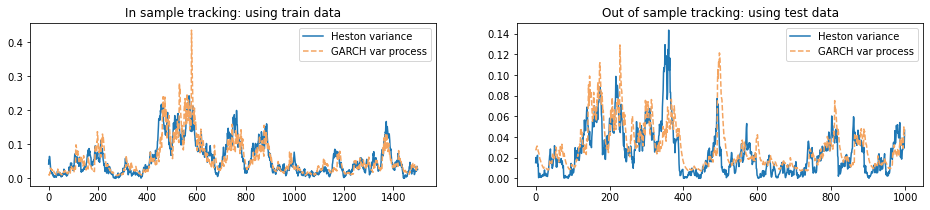

In [26]:
fig = plt.figure(figsize=(16,3))
ax1 = fig.add_subplot(121); ax2 = fig.add_subplot(122)
#ax1.plot((1/(dt*scale_factor**2) ) *res.conditional_volatility**2)    # ARCH method equivalent to generate_var
ax1.plot(V[1:train_size], label="Heston variance"); ax2.plot(V[1+train_size:], label="Heston variance")
ax1.plot(var_train/dt, label="GARCH var process", color='sandybrown', linestyle='--')
ax2.plot(var_test/dt, label="GARCH var process", color='sandybrown', linestyle='--')
ax1.set_title("In sample tracking: using train data"); ax2.set_title("Out of sample tracking: using test data")
ax1.legend();ax2.legend(); plt.show()

<a id='sec2.3'></a>
### Rolling Variance

In [27]:
window = 20
ret_df = pd.Series(ret_log, index=T_vec[1:])
roll_var = ret_df.rolling(window).var(ddof=0) / dt   # MLE estimate

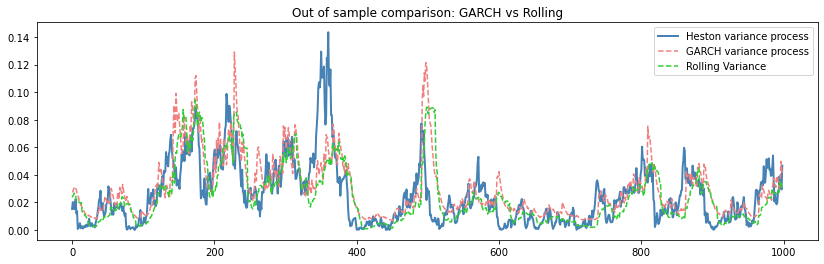

In [28]:
fig = plt.figure(figsize=(14,4))
plt.plot( V[train_size+1:] , label="Heston variance process", linewidth=2, color="steelblue" )
plt.plot( var_test/dt, label="GARCH variance process", color='lightcoral', linestyle='--' )
plt.plot( roll_var.values[train_size:], label="Rolling Variance", linestyle='--', alpha=1, color="limegreen")
plt.title("Out of sample comparison: GARCH vs Rolling")
plt.legend(); plt.show()

<a id='sec3'></a>
# Kalman filter

In this section I'm going to present the model initially proposed by Taylor [2], with the linearization and estimation method described in Harvey, Ruiz and Shephard, [3], [4] and [5].

#### Model linearization:

Let us consider the model for the returns defined before:

$$ R_{t} = \sqrt{v_t}\, e_{t}  \quad \text{with} \quad e_{t} \sim \mathcal{N}(0,1).  $$

It is quite useful to introduce an additional scale parameter $\bar \sigma$, such that the model becomes: 

$$ R_{t} = \bar \sigma \sqrt{v_t}\, e_{t}  \quad \text{with} \quad e_{t} \sim \mathcal{N}(0,1).  $$

This model is multiplicative. The first thing that comes to mind is to take the log transform to make it linear!!     
If you remember, already in the notebook **1.4** we found useful to define the log-variance $h_t := \log v_t$.

In order to remove the square root, we can square the equation on both sides, and then take the logarithm:

$$ \begin{aligned}
\log R_{t}^2 &= \log \big( \bar \sigma^2 \, v_t \, e_{t}^2 \big) \\
             &= \log \bar \sigma^2 \,+ \log v_t \,+ \log e_{t}^2 \; \pm \; \mathbb{E}\big[\log e_{t}^2 \big] \\
             &= \log \bar \sigma^2 \,+ \mathbb{E}\big[\log e_{t}^2 \big] + h_t + \epsilon_t 
\end{aligned} $$

Where we called $\epsilon_t := \log e_{t}^2 - \mathbb{E}\big[\log e_{t}^2 \big]$.       

We want to create a state space model with an hidden state variable (see notebook **5.1** for a review of the general theory).
The hidden variable in this model is the log-variance. We can assume it follows an autoregressive process: 

$$ h_t = \phi h_{t-1} + \eta_t \quad \text{with} \quad \eta_{t} \sim \mathcal{N}(0,\sigma_{\eta}^2), $$

with $|\phi|\leq 1$.     
However, the resulting system (state equation in $\log v_t$ and measurement equation in $\log R_t^2$) is NOT a linear Gaussian state space model.     
The reason is that the random variable 

$$\log e_{t}^2 \sim Log \chi^2_1$$ 

is not Gaussian, but follows the Log-Chi-Squared distribution with 1 degree of freedom.     
It satisfies $\mathbb{E}\big[\log e_{t}^2 \big] \approx -1.27$ and
$Var\big[\log e_{t}^2 \big] = \frac{\pi^2}{2}$.

In order to make the system a linear Gaussian state space model, we can approximate 

$$ \epsilon_t \sim \mathcal{N}\bigg(0,\frac{\pi^2}{2} \bigg). $$

Let us check if this approximation is good:

In [29]:
def log_chi2(x):
    """ Log-Chi-Squared density """
    return 1/np.sqrt(2*np.pi) * np.exp( x/2 - np.exp(x)/2 )

In [30]:
mean_chi2 = quad(lambda x: x*log_chi2(x), -30, 10)[0]
var_chi2 = quad(lambda x: ((x-mean_chi2)**2)*log_chi2(x), -50, 10)[0]
print("Mean of the Log-Chi-Squared", round(mean_chi2,4) )
print("Variance of the Log-Chi-Squared", round(var_chi2,4) )

Mean of the Log-Chi-Squared -1.2704
Variance of the Log-Chi-Squared 4.9348


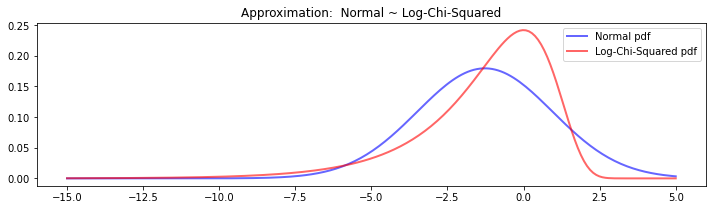

In [31]:
fig = plt.figure(figsize=(12,3)); x = np.linspace(-15, 5, 200)
plt.plot(x, ss.norm.pdf(x, loc=mean_chi2, scale=np.sqrt(var_chi2)), 'b-', lw=2, alpha=0.6, label='Normal pdf')
plt.plot(x, log_chi2(x), 'r-', lw=2, alpha=0.6, label='Log-Chi-Squared pdf')
plt.title("Approximation:  Normal ~ Log-Chi-Squared"); plt.legend(); plt.show()

Well... it doesn't seem so good at first sight.      
But it is proved in many articles (see references in [3] and [4]) that this approximation is good enough to produce a nice output.      
Indeed, this method is quite used in practice.

<a id='sec3.1'></a>
### Gaussian linear state space model:

**State equation:**

$$ h_k = \phi h_{k-1} + \eta_k \quad \text{with} \quad \eta_{k} \sim \mathcal{N}(0,\sigma_{\eta}^2). $$

**Measurment equation:**

$$ \bigg( \log R_{k}^2 + 1.27 -\log \bar \sigma^2 \bigg)= \; h_k + \epsilon_k \quad \text{with} \quad \epsilon_k \sim \mathcal{N}\bigg(0,\frac{\pi^2}{2} \bigg).$$

### Kalman filter:

Let us identify the Kalman filter elements. You can find them in the notebook **5.1** or in the [wiki page](https://en.wikipedia.org/wiki/Kalman_filter#Details).

In this model $F_k = \phi$ and $ H_k=1$ are constant. They do not depend on $k$.    

##### Predict step:
$$ \hat h_{k \mid k-1} = \phi\, \hat h_{k-1 \mid k-1} \quad \quad \text{and} \quad \quad  P_{k \mid k-1} = \phi^2 \, P_{k-1 \mid k-1} + \sigma_{\eta}^2. $$

##### Auxiliary variables:
$$ 
\begin{aligned}
\tilde y_k &= \log R_{k}^2 + 1.27 -\log \bar \sigma^2 \, - \hat h_{k \mid k-1} &\quad \quad \text{(pre-fit residual)} \\
S_k &= P_{k \mid k-1} + \frac{\pi^2}{2} &\quad \quad \text{(conditional innovation covariance)} \\
K_k &= \frac{P_{k \mid k-1}}{S_k} &\quad \quad \text{(Kalman Gain)}
\end{aligned}
$$

##### Update step:
$$ \hat h_{k \mid k} = \hat h_{k \mid k-1} + K_k \, \tilde y_k  \quad \text{and} \quad 
P_{k \mid k} = P_{k \mid k-1} \biggl( 1- K_k \biggr)
$$

In order to familiarize with these formulas, let us compute the conditional expectation and variance of the innovations i.e. the new measurements:

$$ \mathbb{E}\bigg[ \log R_k^2 \, \bigg|\, \hat h_{k-1 \mid k-1} \bigg] = \, -1.27 \,+ \log \bar \sigma^2 \, + \hat h_{k \mid k-1} $$

$$ \text{Var} \bigg[ \log R_k^2 \, \bigg|\, \hat h_{k-1 \mid k-1} \bigg] = \, P_{k \mid k-1} + \frac{\pi^2}{2} \; = S_k $$


### Log-likelihood

The parameters $(\phi, \sigma_{\eta},\bar \sigma)$ can be estimated using the QML method (Quasi-Maximum-Likelihood), where the "Quasi" refers to the Gaussian approximation of $\epsilon_k$.     
The log-likelihood function is:

$$ \log L \big( \phi, \sigma_{\eta},\bar \sigma \mid R_k, R_{k-1}, ..., R_1, R_0 \big) = -\frac{1}{2} 
\sum_{k=1}^N \biggl( \log 2\pi + \log S_k + \frac{\tilde y_k^2}{S_k}  \biggr)
$$

In [32]:
h0 = np.log(train.var())   # initial value for the log-variance
P0 = 100                   # initial variance of the log-variance

Above I chose an initial hidden state $h_0$ equal to the logarithm of the variance computed in the training set.   
Since we have no knowledge of the true value of $h_0$, it is better to select a huge value of the initial error $P_0 = 100$.

In the function below, I indicate $\bar \sigma$ with `scale`, and the residuals $\tilde y_k$ with `r`. 

<a id='sec3.2'></a>
## Algorithm implementation:

In [33]:
def Kalman(data, h0, P0, phi, var_eta, scale ):
    """ One dimensional Kalman filter algorithm """
    
    Y = np.log(data**2)             # take the log of squared data
    N = len(Y)                       
    hs = np.zeros_like(Y)           # Initialization
    Ps = np.zeros_like(Y)
        
    Y = Y + 1.27 - np.log(scale**2)       # redefine Y. scale corresponds to \bar{\sigma} 
    h = h0; P = P0                        # initial values of h and P
    log_2pi = np.log(2 * np.pi); loglikelihood = 0      # initialize log-likelihood
    
    for k in range(N):
        # Prediction step
        h_p = phi * h                   # predicted h
        P_p = phi**2 * P + var_eta      # predicted P

        # auxiliary variables
        r = Y[k] - h_p                 # residual
        S = P_p + 0.5 * np.pi**2
        KG = P_p / S                   # Kalman Gain
        
        # Update step
        h = h_p + KG * r
        P = P_p * (1 - KG)

        loglikelihood += -0.5 * ( log_2pi + np.log(S) + (r**2/S) )      
        hs[k] = h; Ps[k] = P
        
    return hs, Ps, loglikelihood

The log-likelihood function may have multiple local minima. For this reason, remember to repeat the minimization several times with different initial conditions. (For instance, if you try `x0=[0.1, 0.5, 1]` you will get different locally optimal values)

##### Parameter estimation:

In [34]:
def minus_likelihood(c):
    """ Returns the negative log-likelihood """
    _, _, loglik = Kalman(train, h0, P0, c[0], c[1], c[2])
    return -loglik
        
result = minimize(minus_likelihood, x0=[0.1, 1, 1], 
                      method='L-BFGS-B', bounds=[[-1,1],[1e-15,None],[1e-15,None]], tol=1e-8)
kalman_params = result.x
print(result)

      fun: 3374.975321609764
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.0041382 , -0.00095497, -0.01996341])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 136
      nit: 18
     njev: 34
   status: 0
  success: True
        x: array([0.97760755, 0.0371697 , 0.01228061])


In [35]:
hs, Ps, _ = Kalman(train, h0, P0, *kalman_params)                  # Kalman on training set
h_test, P_test, _ = Kalman(test, hs[-1], Ps[-1], *kalman_params)   # Kalman on test set

In [36]:
phi = kalman_params[0]
var_eta = kalman_params[1]
scale = kalman_params[2]

##### Kalman Smoother:

Let's implement the [RTS](https://en.wikipedia.org/wiki/Kalman_filter#Rauch%E2%80%93Tung%E2%80%93Striebel) smoother:

In [37]:
hs_smooth = np.zeros_like(h_test)
Ps_smooth = np.zeros_like(P_test)
hs_smooth[-1] = h_test[-1] 
Ps_smooth[-1] = P_test[-1]
    
for k in range( len(h_test)-2,-1,-1):
    C = phi * P_test[k] / (phi**2 * P_test[k] + var_eta)  
    hs_smooth[k] = h_test[k] + C*( hs_smooth[k+1] - h_test[k]*phi )
    Ps_smooth[k] = P_test[k] + C**2 *( Ps_smooth[k+1] - (phi**2 * P_test[k] + var_eta) )

smooth_h = np.exp(hs_smooth)/dt*scale**2                     # Kalman re-transformed variance

In [38]:
V_kalm = np.exp(h_test)/dt*scale**2                     # Kalman re-transformed variance  
V_up = np.exp(h_test+np.sqrt(P_test))/dt*scale**2       # error up bound 
V_down = np.exp(h_test-np.sqrt(P_test))/dt*scale**2     # error down bound    

##### Plots:

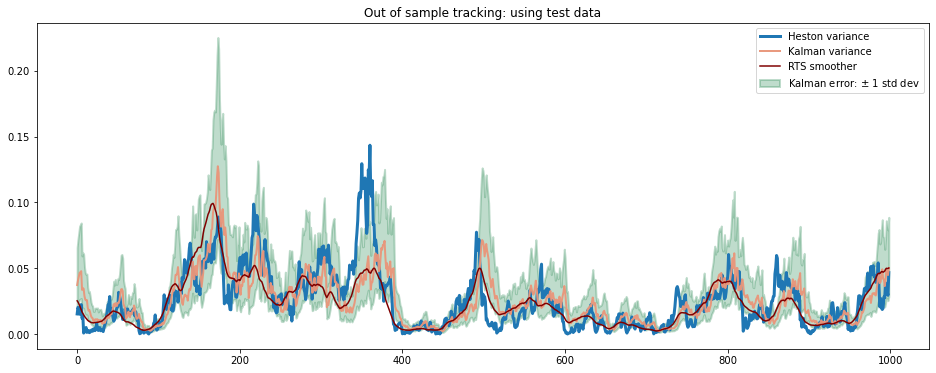

In [39]:
fig = plt.figure(figsize=(16,6))
plt.plot( V[1+train_size:], label="Heston variance", linewidth=3)
plt.plot( V_kalm, label="Kalman variance", color='darksalmon', linestyle='-', linewidth=2, alpha=10)
plt.fill_between(x=range(len(h_test)) ,y1=V_up, y2=V_down, 
                 alpha=0.3, linewidth=2, color='seagreen', label="Kalman error: $\pm$ 1 std dev ")
plt.plot( smooth_h, label="RTS smoother", color="maroon" )
plt.title("Out of sample tracking: using test data"); plt.legend(); plt.show()

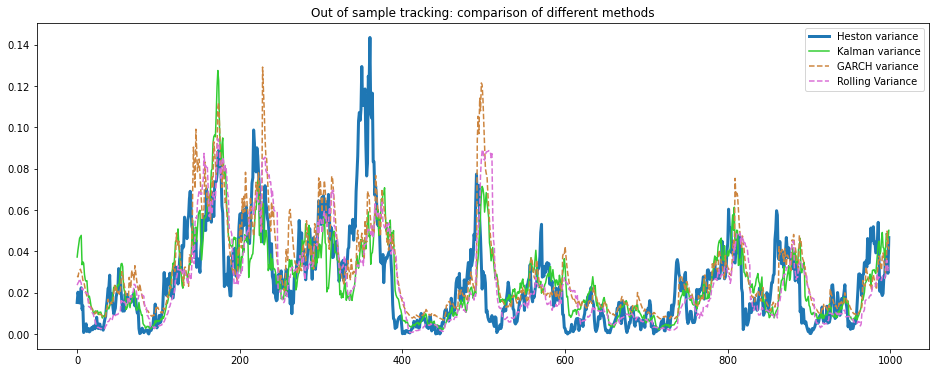

In [40]:
fig = plt.figure(figsize=(16,6))
plt.plot(V[1+train_size:], label="Heston variance", linewidth=3)
plt.plot( V_kalm, label="Kalman variance", color='limegreen', linestyle='-')
plt.plot(var_test/dt, label="GARCH variance", color='peru', linestyle='--')
plt.plot( roll_var.values[train_size:], label="Rolling Variance", linestyle='--', alpha=1, color="orchid")
plt.title("Out of sample tracking: comparison of different methods"); plt.legend(); plt.show()

It is not easy to compare the methods by looking at the plot. Let's have a look at the MSE (mean square error):

In [42]:
print("MSE Kalman: ", np.mean( (V[1+train_size:] - V_kalm)**2 ) )
print("MSE GARCH: ", np.mean( (V[1+train_size:] - var_test/dt)**2 ) )
print("MSE Rolling: ", np.mean( (V[1+train_size:] - roll_var.values[train_size:])**2 ) )
print("MSE Smoother: ", np.mean( (V[1+train_size:] - smooth_h)**2 ) )

MSE Kalman:  0.000310967950616797
MSE GARCH:  0.00036177545392460754
MSE Rolling:  0.0003791184919051251
MSE Smoother:  0.00021729917496004827


#### The Kalman filter approach is the best!

## References

[1] Giuseppe Cavaliere (2006) - "Unit root tests under time-varying variances"

[2] Taylor, S. J. (1986) - "Modelling Financial Time Series"

[3] Harvey, A. C., and Shephard, N. (1993) - "Estimation and Testing of Stochastic Variance Models"

[4] Harvey, A. C., Ruiz, E., and Shephard, N. (1994) - "Multivariate Stochastic Variance Models"

[5] Ruiz, E. (1994) - "Quasi-Maximum Likelihood Estimation of Stochastic Volatility Models"